# Exercise 4: Circuit Decomposition
Wow! If you managed to solve the first three exercises, congratulations! The fourth problem is supposed to puzzle even the quantum experts among you, so don’t worry if you cannot solve it. If you can, hats off to you!

You may recall from your quantum mechanics course that quantum theory is unitary. Therefore, the evolution of any (closed) system can be described by a unitary. But given an arbitrary unitary, can you actually implement it on your quantum computer?

**"A set of quantum gates is said to be universal if any unitary transformation of the quantum data can be efficiently approximated arbitrarily well as a sequence of gates in the set."** (https://qiskit.org/textbook/ch-algorithms/defining-quantum-circuits.html)

Every gate you run on the IBM Quantum Experience is transpiled into single qubit rotations and CNOT (CX) gates. We know that these constitute a universal gate set, which implies that any unitary can be implemented using only these gates. However, in general it is not easy to find a good decomposition for an arbitrary unitary. Your task is to find such a decomposition.

You are given the following unitary:

In [1]:
from may4_challenge.ex4 import get_unitary
U = get_unitary()
# print(U)
print("U has shape", U.shape)

U has shape (16, 16)


#### What circuit would make such a complicated unitary?

Is there some symmetry, or is it random? We just updated Qiskit with the introduction of a quantum circuit library (https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library). This library gives users access to a rich set of well-studied circuit families, instances of which can be used as benchmarks (quantum volume), as building blocks in building more complex circuits (adders), or as tools to explore quantum computational advantage over classical computation (instantaneous quantum polynomial complexity circuits).

In [2]:
from qiskit import QuantumCircuit
from may4_challenge.ex4 import check_circuit, submit_circuit

**Using only single qubit rotations and CNOT gates, find a quantum circuit that approximates that unitary $U$ by a unitary $V$ up to an error $\varepsilon = 0.01$, such that $\lVert U - V\rVert_2 \leq \varepsilon$ !** 

Note that the norm we are using here is the spectral norm, $\qquad \lVert A \rVert_2 = \max_{\lVert \psi \rVert_2= 1} \lVert A \psi \rVert$.

This can be seen as the largest scaling factor that the matrix $A$ has on any initial (normalized) state $\psi$. One can show that this norm corresponds to the largest singular value of $A$, i.e., the square root of the largest eigenvalue of the matrix $A^\dagger A$, where $A^{\dagger}$ denotes the conjugate transpose of $A$.

**When you submit a circuit, we remove the global phase of the corresponding unitary $V$ before comparing it with $U$ using the spectral norm. For example, if you submit a circuit that generates $V = \text{e}^{i\theta}U$, we remove the global phase $\text{e}^{i\theta}$ from $V$ before computing the norm, and you will have a successful submission. As a result, you do not have to worry about matching the desired unitary, $U$, up to a global phase.**

As the single-qubit gates have a much higher fidelity than the two-qubit gates, we will look at the number of CNOT-gates, $n_{cx}$, and the number of u3-gates, $n_{u3}$, to determine the cost of your decomposition as 

$$
\qquad \text{cost} = 10 \cdot n_{cx} + n_{u3}
$$

Try to optimize the cost of your decomposition. 

**Note that you will need to ensure that your circuit is composed only of $u3$ and $cx$ gates. The exercise is considered correctly solved if your cost is smaller than 1600.**

---
For useful tips to complete this exercise as well as pointers for communicating with other participants and asking questions, please take a look at the following [repository](https://github.com/qiskit-community/may4_challenge_exercises). You will also find a copy of these exercises, so feel free to edit and experiment with these notebooks.

---

# SOLUTION STARTS HERE

In [3]:
# Let's import everything we need
from qiskit.compiler import transpile, assemble
from qiskit import execute, Aer
U_simulator = Aer.get_backend('unitary_simulator')

The first thing to try, is to simply attach the unitary to a quantum circuit, transpile it, and see what we get.

To attach the unitary to a circuit we will use the isometry feature: 

https://qiskit.org/documentation/_modules/qiskit/extensions/quantum_initializer/isometry.html

In case you don't know what transpiling means, it is basically taking some code in a given programing language (in our case, general gates like H, NOT, CZ, etc), and translating it into code of a different level of abstraction (in this case, a set of universal gates like U3 rotations and CX). For more information check out qiskit's documentation: 

https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html

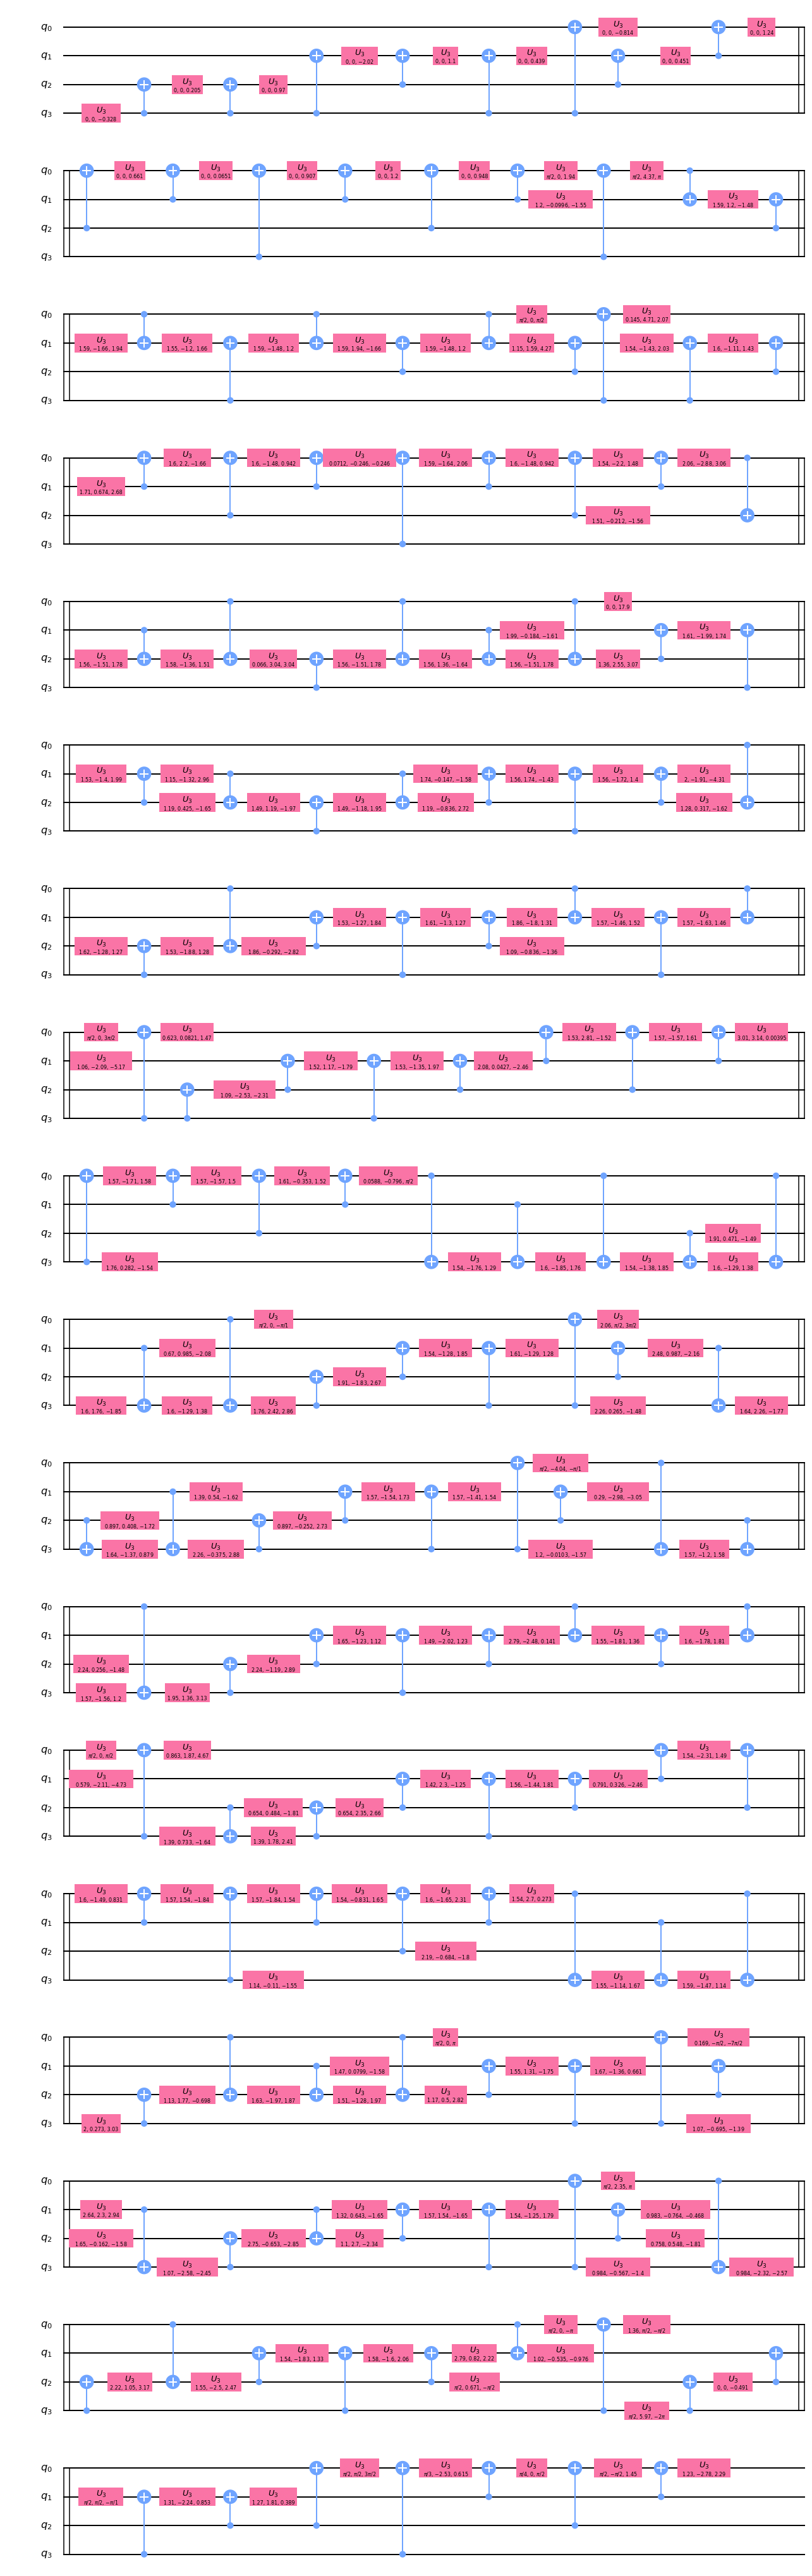

In [4]:
qc1 = QuantumCircuit(4)
qc1.iso(U, [0,1,2,3], [])
qc1 = transpile(qc1, basis_gates = ['u3', 'cx'], optimization_level=2,)
qc1.draw(output='mpl')

Wow!

That's quite a large circuit. Let's pass it to the circuit checker and see how we're doing

In [5]:
check_circuit(qc1)

Circuit stats:
||U-V||_2 = 4.2634217757239e-14
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 1663

Something is not right with your circuit: the cost of the circuit is too high (above 1600)


So, as expected, our V circuit is very close (almost identical) to the desired circuit U.

However, our circuit has too many gates! Let's analyze the unitary to see if there is anything we can do to simplify

For that, generating a heatmap of the matrix might be helpful. We can look for symmetry or patterns to see if there is something we can simplify

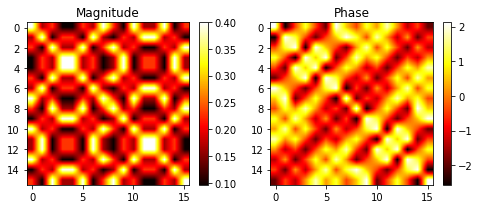

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
im1 = axs[0].imshow(np.abs(U), cmap='hot', interpolation='bilinear')
axs[0].set_title('Magnitude')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.angle(U), cmap='hot', interpolation='bilinear')
axs[1].set_title('Phase')
fig.colorbar(im2, ax=axs[1])
plt.show()

# WARNING: 
# Here I've used 'bilinear' interpolation to make the figures look "pretty", 
# however, it might be better to use 'nearest' interpolation to see the actual values of the matrix cells

There is clearly some symmetry here!

Maybe if we look at the unitary in Fourier space we'll see something interesting. Think about this as trying to take a very complicated time-domain signal (like the recording of sound) and looking at it in the frequency domain, where we can see more clearly what frequency components make part of our recording.

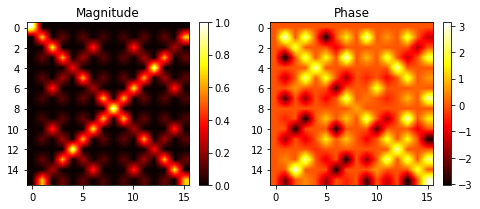

In [7]:
# Function to generate the QFT operation for n qubits
def QFT_mat(n):
    NN = 2**n
    QFN = np.zeros([NN,NN],dtype=np.complex_)
    for i in range(NN):
        for j in range(NN):
            if (i == 0) or (j == 0):
                QFN[i,j] = 1
            else:
                QFN[i,j] = np.exp((2*np.pi*1j)*(i*j)/NN)
    return QFN

QF4 = QFT_mat(4) # 4 qubit QFT matrix
QF4_inv = np.linalg.inv(QF4) # 4 qubit inverse QFT matrix

QUQ = np.matmul(QF4_inv,np.matmul(U,QF4))

# The following for loop is to replace very small values ( < 1e-14) from computational error with zero,
# this way when calculating the phase we will get zero rather than random values
for i in range(len(QUQ)):
        for j in range(len(QUQ[i])):
                if 0 < np.real(QUQ[i,j]) < 1e-14:
                    QUQ[i,j] = 0 + 1j*(np.imag(QUQ[i,j]))
                if -1e-14 < np.real(QUQ[i,j]) < 0:
                    QUQ[i,j] = 0 + 1j*(np.imag(QUQ[i,j]))
                if 0 < np.imag(QUQ[i,j]) < 1e-14:
                    QUQ[i,j] = np.real(QUQ[i,j]) + 1j*0
                if -1e-14 < np.imag(QUQ[i,j]) < 1e-14:
                    QUQ[i,j] = np.real(QUQ[i,j]) + 1j*0

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
im1 = axs[0].imshow(np.abs(QUQ), cmap='hot', interpolation='bilinear')
axs[0].set_title('Magnitude')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.angle(QUQ), cmap='hot', interpolation='bilinear')
axs[1].set_title('Phase')
fig.colorbar(im2, ax=axs[1])
plt.show()

Interesting!

Several of the magnitudes within the matrix are zero. The terms along some diagonals remain. This says that if we work in Fourier space, we might end up with a lot less gates.

But remember, after completing exercise 3, the clue given was "Hadamard", so let's look in that space, maybe we can do better.

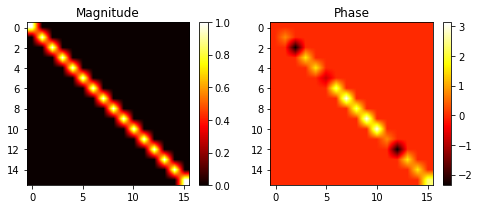

In [8]:
# Interesting! Several of the magnitudes within the matrix have gone to zero!
# Terms along the diagonals remain.
# Now remember! After completing exercise 3, the clue given was "Hadamard", so let's look in that space

H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]]) # 1 qubit Hadamard

H4 = np.kron(H,np.kron(H,np.kron(H,H))) # 4 qbuit Hadamard
UHU = HUH = np.matmul(H4,np.matmul(U,H4))

for i in range(len(HUH)):
        for j in range(len(HUH[i])):
                if 0 < np.real(HUH[i,j]) < 1e-14:
                    HUH[i,j] = 0 + 1j*(np.imag(HUH[i,j]))
                if -1e-14 < np.real(HUH[i,j]) < 0:
                    HUH[i,j] = 0 + 1j*(np.imag(HUH[i,j]))
                if 0 < np.imag(HUH[i,j]) < 1e-14:
                    HUH[i,j] = np.real(HUH[i,j]) + 1j*0
                if -1e-14 < np.imag(HUH[i,j]) < 1e-14:
                    HUH[i,j] = np.real(HUH[i,j]) + 1j*0

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
im1 = axs[0].imshow(np.abs(HUH), cmap='hot', interpolation='bilinear')
axs[0].set_title('Magnitude')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.angle(HUH), cmap='hot', interpolation='bilinear')
axs[1].set_title('Phase')
fig.colorbar(im2, ax=axs[1])
plt.show()

Fantastic! 

Most terms go to zero, with the exception of the diagonal. Let's now take this new unitary in Hadamard space, and attach it to a new circuit to see if we get a better cost. Now remember, this new unitary is in Hadamard space, but we want the final circuit to represent our original unitary, so we need Hadamard gates before and after our new matrix.

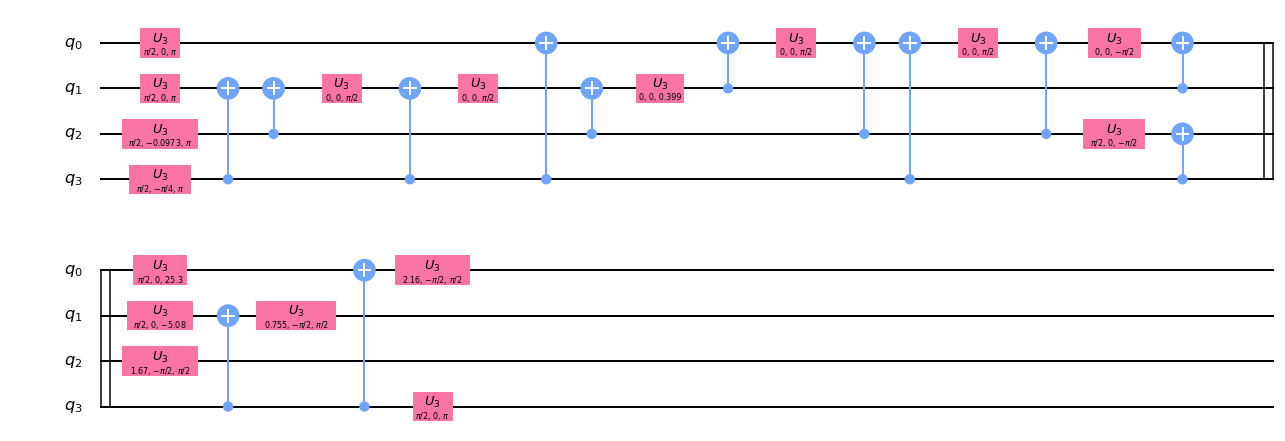

In [9]:
qc2 = QuantumCircuit(4)
qc2.h([0,1,2,3])
qc2.iso(HUH, [0,1,2,3], [])
qc2.h([0,1,2,3])
qc2 = transpile(qc2, basis_gates = ['u3', 'cx'], optimization_level=2,)
qc2.draw(output='mpl')

In [10]:
check_circuit(qc2)

Circuit stats:
||U-V||_2 = 2.678288075720112e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 147

Great! Your circuit meets all the constrains.
Your score is 147. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


Awesome! 

We've managed to solve the problem. Our cost is way below the target of 1600.

The question at this point is, can we do any better?

Let's try to understand what this unitary operator is really doing. First off, let's remember what having a normalized diagonal operator implies. Let's do this with an example.

Let's consider the following 2-qubit unitary operator:

$U = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & \frac{1}{\sqrt{2}} \left(1 + i \right)  & 0 \\ 0 & 0 & 0 & 1 \\  \end{bmatrix}$

We can see that all this operator does is the following mapping for each possible state:

$ |00 \rangle \rightarrow |00 \rangle $

$ |01 \rangle \rightarrow - |01 \rangle $

$ |10 \rangle \rightarrow \frac{1}{\sqrt{2}} \left(1 + i \right) |10 \rangle $

$ |11 \rangle \rightarrow |11 \rangle $

Or, in other words, it adds a relative phase to each state:

$ |00 \rangle \rightarrow e^{0 i} |00 \rangle $

$ |01 \rangle \rightarrow e^{\pi i} |01 \rangle $

$ |10 \rangle \rightarrow e^{\frac{\pi}{4} i} |10 \rangle $

$ |11 \rangle \rightarrow e^{0 i} |11 \rangle $

So, now let's look at the components of our 16x16 matrix in Hadamard space $HUH$, and see what are the phases for each of the states.

In [11]:
np.diagonal(HUH)

array([ 1.        +0.j        ,  0.70710678+0.70710678j,
       -0.70710678-0.70710678j,  0.        +1.j        ,
        0.        +1.j        ,  0.70710678-0.70710678j,
       -0.70710678+0.70710678j, -1.        +0.j        ,
       -0.70710678+0.70710678j, -1.        +0.j        ,
       -1.        +0.j        ,  0.70710678+0.70710678j,
       -0.70710678-0.70710678j,  0.        +1.j        ,
        0.        +1.j        , -0.70710678+0.70710678j])

So, we have a diagonal with terms:

$ \begin{bmatrix} 1, \frac{1}{\sqrt{2}} \left(1 + i \right), \frac{-1}{\sqrt{2}} \left(1 + i \right), i, i, \frac{1}{\sqrt{2}} \left(1 - i \right), \frac{-1}{\sqrt{2}} \left(1 - i \right), -1, \frac{-1}{\sqrt{2}} \left(1 - i \right), -1, -1, \frac{1}{\sqrt{2}} \left(1 + i \right), \frac{-1}{\sqrt{2}} \left(1 + i \right), i, i, \frac{-1}{\sqrt{2}} \left(1 - i \right) \end{bmatrix} $

This might seem a bit overwhelming at first, but if instead of looking at these values in catersian form $\left(a + ib \right)$, we look at them in polar representation $ \left(r e^{\theta i} \right) $ we  get:

$ \begin{bmatrix} e^{0 i}, e^{\frac{\pi}{4} i}, e^{\frac{-3\pi}{4} i}, e^{\frac{\pi}{2} i}, e^{\frac{\pi}{2} i}, e^{\frac{-\pi}{4} i}, e^{\frac{3\pi}{4} i}, e^{\pi i}, e^{\frac{3\pi}{4} i}, e^{\pi i}, e^{\pi i}, e^{\frac{\pi}{4} i}, e^{\frac{-3\pi}{4} i}, e^{\frac{\pi}{2} i}, e^{\frac{\pi}{2} i}, e^{\frac{-\pi}{4} i} \end{bmatrix} $

Therefore, state $ | 0000 \rangle $ would pick up a phase of 0, state $ | 0001 \rangle $ a phase of $ \frac{\pi}{4} $, state $ | 0010 \rangle $ a phase of $ \frac{-3\pi}{4} $, and so on.

Here's the list of just the phases (without the exponential):

$ \begin{bmatrix} 0, & \frac{\pi}{4}, & \frac{-3\pi}{4}, & \frac{\pi}{2}, & \frac{\pi}{2}, & \frac{-\pi}{4}, & \frac{3\pi}{4}, & \pi, & \frac{3\pi}{4}, & \pi, & \pi, & \frac{\pi}{4}, & \frac{-3\pi}{4}, & \frac{\pi}{2}, & \frac{\pi}{2}, & \frac{-\pi}{4} \end{bmatrix} $

Now we have some intuition about what the operator is doing, so we can start putting together a circuit representation for it. The first thing to note is that the phase-shift associated with states where only one qubit is flipped (i.e., $ | 0001 \rangle $, $ | 0010 \rangle $, $ | 0100 \rangle $ and $ | 1000 \rangle $) are $\frac{\pi}{4} $, $\frac{-3\pi}{4} $, $ \frac{\pi}{2}$, and $\frac{3\pi}{4} $, respectively.

We can then associate a single-qubit rotation gate to each of the corresponding qubits.

Now, let's implement a circuit that only contains these gates, and let's see how different the unitary of it is from what we really want (the matrix $HUH$). 

We will do this implementation using u3 gates so. For more information about how the angles above are incorporated into the values $\theta, \phi, \lambda$ of the u3 gates please refer to: 

https://qiskit-staging.mybluemix.net/documentation/terra/summary_of_quantum_operations.html

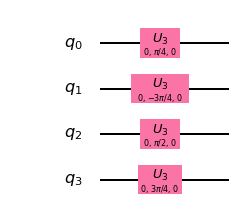

In [12]:
qcp = QuantumCircuit(4)
qcp.u3(0,np.pi/4,0,0)
qcp.u3(0,-3*np.pi/4,0,1)
qcp.u3(0,np.pi/2,0,2)
qcp.u3(0,3*np.pi/4,0,3)
qcp.draw(output='mpl')

In [13]:
result = execute(qcp, backend = U_simulator).result()
P = result.get_unitary()
np.diagonal(P) # we print only the diagonal because we know the circuit will generate a diagonal matrix

array([ 1.00000000e+00+0.00000000e+00j,  7.07106781e-01+7.07106781e-01j,
       -7.07106781e-01-7.07106781e-01j,  0.00000000e+00-1.00000000e+00j,
        6.12323400e-17+1.00000000e+00j, -7.07106781e-01+7.07106781e-01j,
        7.07106781e-01-7.07106781e-01j,  1.00000000e+00-6.12323400e-17j,
       -7.07106781e-01+7.07106781e-01j, -1.00000000e+00+2.22044605e-16j,
        1.00000000e+00+0.00000000e+00j,  7.07106781e-01+7.07106781e-01j,
       -7.07106781e-01-7.07106781e-01j, -2.22044605e-16-1.00000000e+00j,
        0.00000000e+00+1.00000000e+00j, -7.07106781e-01+7.07106781e-01j])

So this is what we got:

$ \begin{bmatrix} 1, \frac{1}{\sqrt{2}} \left(1 + i \right), \frac{-1}{\sqrt{2}} \left(1 + i \right), -i, i, \frac{-1}{\sqrt{2}} \left(1 - i \right), \frac{1}{\sqrt{2}} \left(1 - i \right), 1, \frac{-1}{\sqrt{2}} \left(1 - i \right), -1, 1, \frac{1}{\sqrt{2}} \left(1 + i \right), \frac{-1}{\sqrt{2}} \left(1 + i \right), -i, i, \frac{-1}{\sqrt{2}} \left(1 - i \right) \end{bmatrix} $

Again, looking at the phases we have:

$ \begin{bmatrix} 0, & \frac{\pi}{4}, & \frac{-3\pi}{4}, & \frac{-\pi}{2}, & \frac{\pi}{2}, & \frac{3\pi}{4}, & \frac{-\pi}{4}, & 0, & \frac{3\pi}{4}, & \pi, & 0, & \frac{\pi}{4}, & \frac{-3\pi}{4}, & \frac{-\pi}{2}, & \frac{\pi}{2}, & \frac{-\pi}{4} \end{bmatrix} $

Notice that if we compare it with the phases of $HUH$, we almost got exactly what we are looking for. If we subtract the phases of $HUH$ from the ones we get for the circuit to see which differ (and by how much), we get:

$ \begin{bmatrix} 0, & 0, & 0, & \pi, & 0, & \pi, & \pi, & \pi, & 0, & 0, & \pi, & 0, & 0, & \pi, & 0, & 0 \end{bmatrix} $

Great! So now we have a circuit that generates either the exact phase-shift we need for some states, or is $ \pi $ radians off from what we want.

Luckily for us, there is a simple way to generate contional phase-shifts $\pi $ for the remaining states using cz (controlled-z) gates. Let's see how we can do this.

Consider the values of matrix associated with the first three states: 

$ | 0000 \rangle \rightarrow 0 $

$ | 0001 \rangle \rightarrow 0 $ 

$ | 0010 \rangle \rightarrow 0 $ 

$ | 0011 \rangle \rightarrow \pi $

This means we need a cz gate between qubits 0 and 1, so that when both of them are equal to 1, we get a  $\pi$ shift.

We can continue this process for the remaining bits, and find that we will also need cz gates between qubits 0 & 2, qubits 1 & 2, and qubits 1 & 3.

Next, let's see how our final circuit would look like. Remember: we need to add Hadamard gates before and after because we've been working with the $HUH$ matrix.


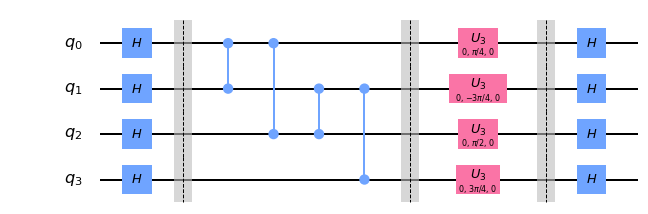

In [14]:
qc4 = QuantumCircuit(4)
qc4.h([0,1,2,3])
qc4.barrier()
qc4.cz(0,1)
qc4.cz(0,2)
qc4.cz(1,2)
qc4.cz(1,3)
qc4.barrier()
qc4.u3(0,np.pi/4,0,0)
qc4.u3(0,np.pi/2,0,2)
qc4.u3(0,-3*np.pi/4,0,1)
qc4.u3(0,3*np.pi/4,0,3)
qc4.barrier()
qc4.h([0,1,2,3])
qc4.draw(output='mpl')

At this point, we could start doing some manual gate reductions by using equivalencies as described here: https://arxiv.org/pdf/1110.2998.pdf. However, since we already have much simpler circuit, we can have the transpile function do the simplification for us.

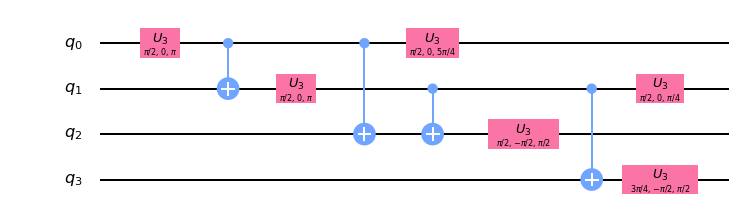

In [15]:
qc5 = QuantumCircuit(4)
qc5.h([0,1,2,3])
qc5.cz(0,1)
qc5.cz(0,2)
qc5.cz(1,2)
qc5.cz(1,3)
qc5.u3(0,np.pi/4,0,0)
qc5.u3(0,np.pi/2,0,2)
qc5.u3(0,-3*np.pi/4,0,1)
qc5.u3(0,3*np.pi/4,0,3)
qc5.h([0,1,2,3])
qc5 = transpile(qc5, basis_gates = ['u3', 'cx'], optimization_level=2,)
qc5.draw(output='mpl')

Awesome!

It seems we did it. Let's check our final score.

In [16]:
check_circuit(qc5)

Circuit stats:
||U-V||_2 = 1.749587988194679e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 46

Great! Your circuit meets all the constrains.
Your score is 46. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


I do not believe there is a way to reduce the cost below 46 for this circuit by doing gate manipulation, so it seems this is the best score we can get using this approach.

What did I learn during this challenge?

- transpile function in qiskit
- isometry feature in qiskit
- How to generate the QFT matrix for n qubits
- How u1, u2, u3 gates operate
- Got better intuition about qubit rotations and the cz gate
- How to decompose gates into a universal set
- How to create a github account :)

You can check whether your circuit is valid before submitting it with `check_circuit(qc)`. Once you have a valid solution, please submit it by running the following cell (delete the `#` before `submit_circuit`). You can re-submit at any time.


In [17]:
# Send the circuit as the final answer, can re-submit at any time
#submit_circuit(qc) 